# Programming Exercise 7: K-means Clustering and Principal Component Analysis

> In this exercise, you will implement the K-means clustering algorithm and apply it to compress an image. In the second part, you will use principal component analysis to find a low-dimensional representation of face images.

## 1. K-means Clustering
> In this this exercise, you will implement the K-means algorithm and use it
for image compression.

### 1.1 Implementing K-means

> The K-means algorithm is a method to automatically cluster similar data examples together. The intuition behind K-means is an iterative procedure that starts by guess- ing the initial centroids, and then refines this guess by repeatedly assigning examples to their closest centroids and then recomputing the centroids based on the assignments.

#### 1.1.1 Finding Closest Centroids

For every example $i$ we set $c_{(i)} := j$ that minimizes $||x^{(i)}-\mu_j||^2$ where $c_{(i)}$ is the index of the centroid that is closest to $x^{(i)}$, and $\mu_j$ is the position (value) of the j'th centroid.

In [1]:
def find_closest_centroid(X, centroids):
    idx = np.zeros((X.shape[0],1))
    for i in range(X.shape[0]):
        idx[i] = np.argmin(np.sqrt(np.sum((X[i,:]-centroids)**2, axis=1)))+1
    return idx

In [2]:
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
mat = scipy.io.loadmat('data/ex7data2.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X'])

In [8]:
K = 3
initial_centroids = np.array([[3,3],[6,2],[8,5]])
idx = find_closest_centroid(mat['X'], initial_centroids)
print('Closest centroids for the first 3 examples:', idx[:3].T)
print('(the closest centroids should be 1, 3, 2 respectively)')

Closest centroids for the first 3 examples: [[1. 3. 2.]]
(the closest centroids should be 1, 3, 2 respectively)


#### 1.1.2 Computing Centroid Means

Given assignments of every point to a centroid, the second phase of the algorithm recomputes, for each centroid, the mean of the points that were assigned to it. Specifically, for every centroid k we set $\mu_k := \frac{1}{|C_k|}\sum_{i \in C_k}x^{(i)}$

In [9]:
def compute_centroids(X, idx, K):
    centroids = np.zeros((K, X.shape[1]))
    for i in range(K):
        centroids[i,:] = np.mean(X[(idx==i+1).T[0], :], axis=0)
    return centroids

In [10]:
centroids = compute_centroids(mat['X'], idx, K)
print('Centroids computed after initial finding of closest centroids: \n', centroids)
print('\n(the centroids should be\n [ 2.428301 3.157924 ]\n[ 5.813503 2.633656 ]\n[ 7.119387 3.616684 ]')

Centroids computed after initial finding of closest centroids: 
 [[2.42830111 3.15792418]
 [5.81350331 2.63365645]
 [7.11938687 3.6166844 ]]

(the centroids should be
 [ 2.428301 3.157924 ]
[ 5.813503 2.633656 ]
[ 7.119387 3.616684 ]


### 1.2 K-means on example dataset

In [11]:
def plot_kmeans(X, centroids, previous, idx, K, axes):
    for i, ax in enumerate(axes):
        sns.scatterplot(x=X[:,0], y=X[:,1], hue=idx.ravel(), legend=False, palette=['r', 'g', 'b'], ax=ax)
        if i==0:
            sns.scatterplot(x=centroids[:,0], y=centroids[:,1], marker='X', color='k', legend=False, s=100, ax=ax)
        else:
            sns.scatterplot(x=centroids[:,0], y=centroids[:,1], marker='X', color='k', legend=False, s=100, ax=ax)
        for i in range(centroids.shape[0]):
            ax.plot([centroids[i,0], previous[i,0]], [centroids[i,1], previous[i,1]], '--k');

In [12]:
def kmeans(X, initial_centroids, max_iters, plot_progress):
    if plot_progress:
        ncols = 3
        nrows = int(max_iters/ncols)
        if max_iters % ncols > 0:
            nrows = nrows + 1
        fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,nrows*8))
        ax_tuple = list(np.ndindex(nrows,ncols))
        for ax in ax_tuple[max_iters:]:
            axes[ax].set_axis_off()
        ax_tuple = ax_tuple[:max_iters]

    K = initial_centroids.shape[0]
    centroids = initial_centroids
    previous_centroids = centroids

    for i in range(max_iters):
        idx = find_closest_centroid(X, centroids)

        if plot_progress:
            plot_axes = [axes[axi] for axi in ax_tuple[i:]]
            axes[ax_tuple[i]].set_title('K-Means iteration {0}/{1}'.format(i+1, max_iters))
            plot_kmeans(X, centroids, previous_centroids, idx, K, plot_axes)
            previous_centroids = centroids
            previous_ax = plt.gca()
        else:
            print('K-Means iteration {0}/{1}'.format(i+1, max_iters))
        centroids = compute_centroids(X, idx, K)

    if plot_progress:
        plt.show()
    return centroids, idx

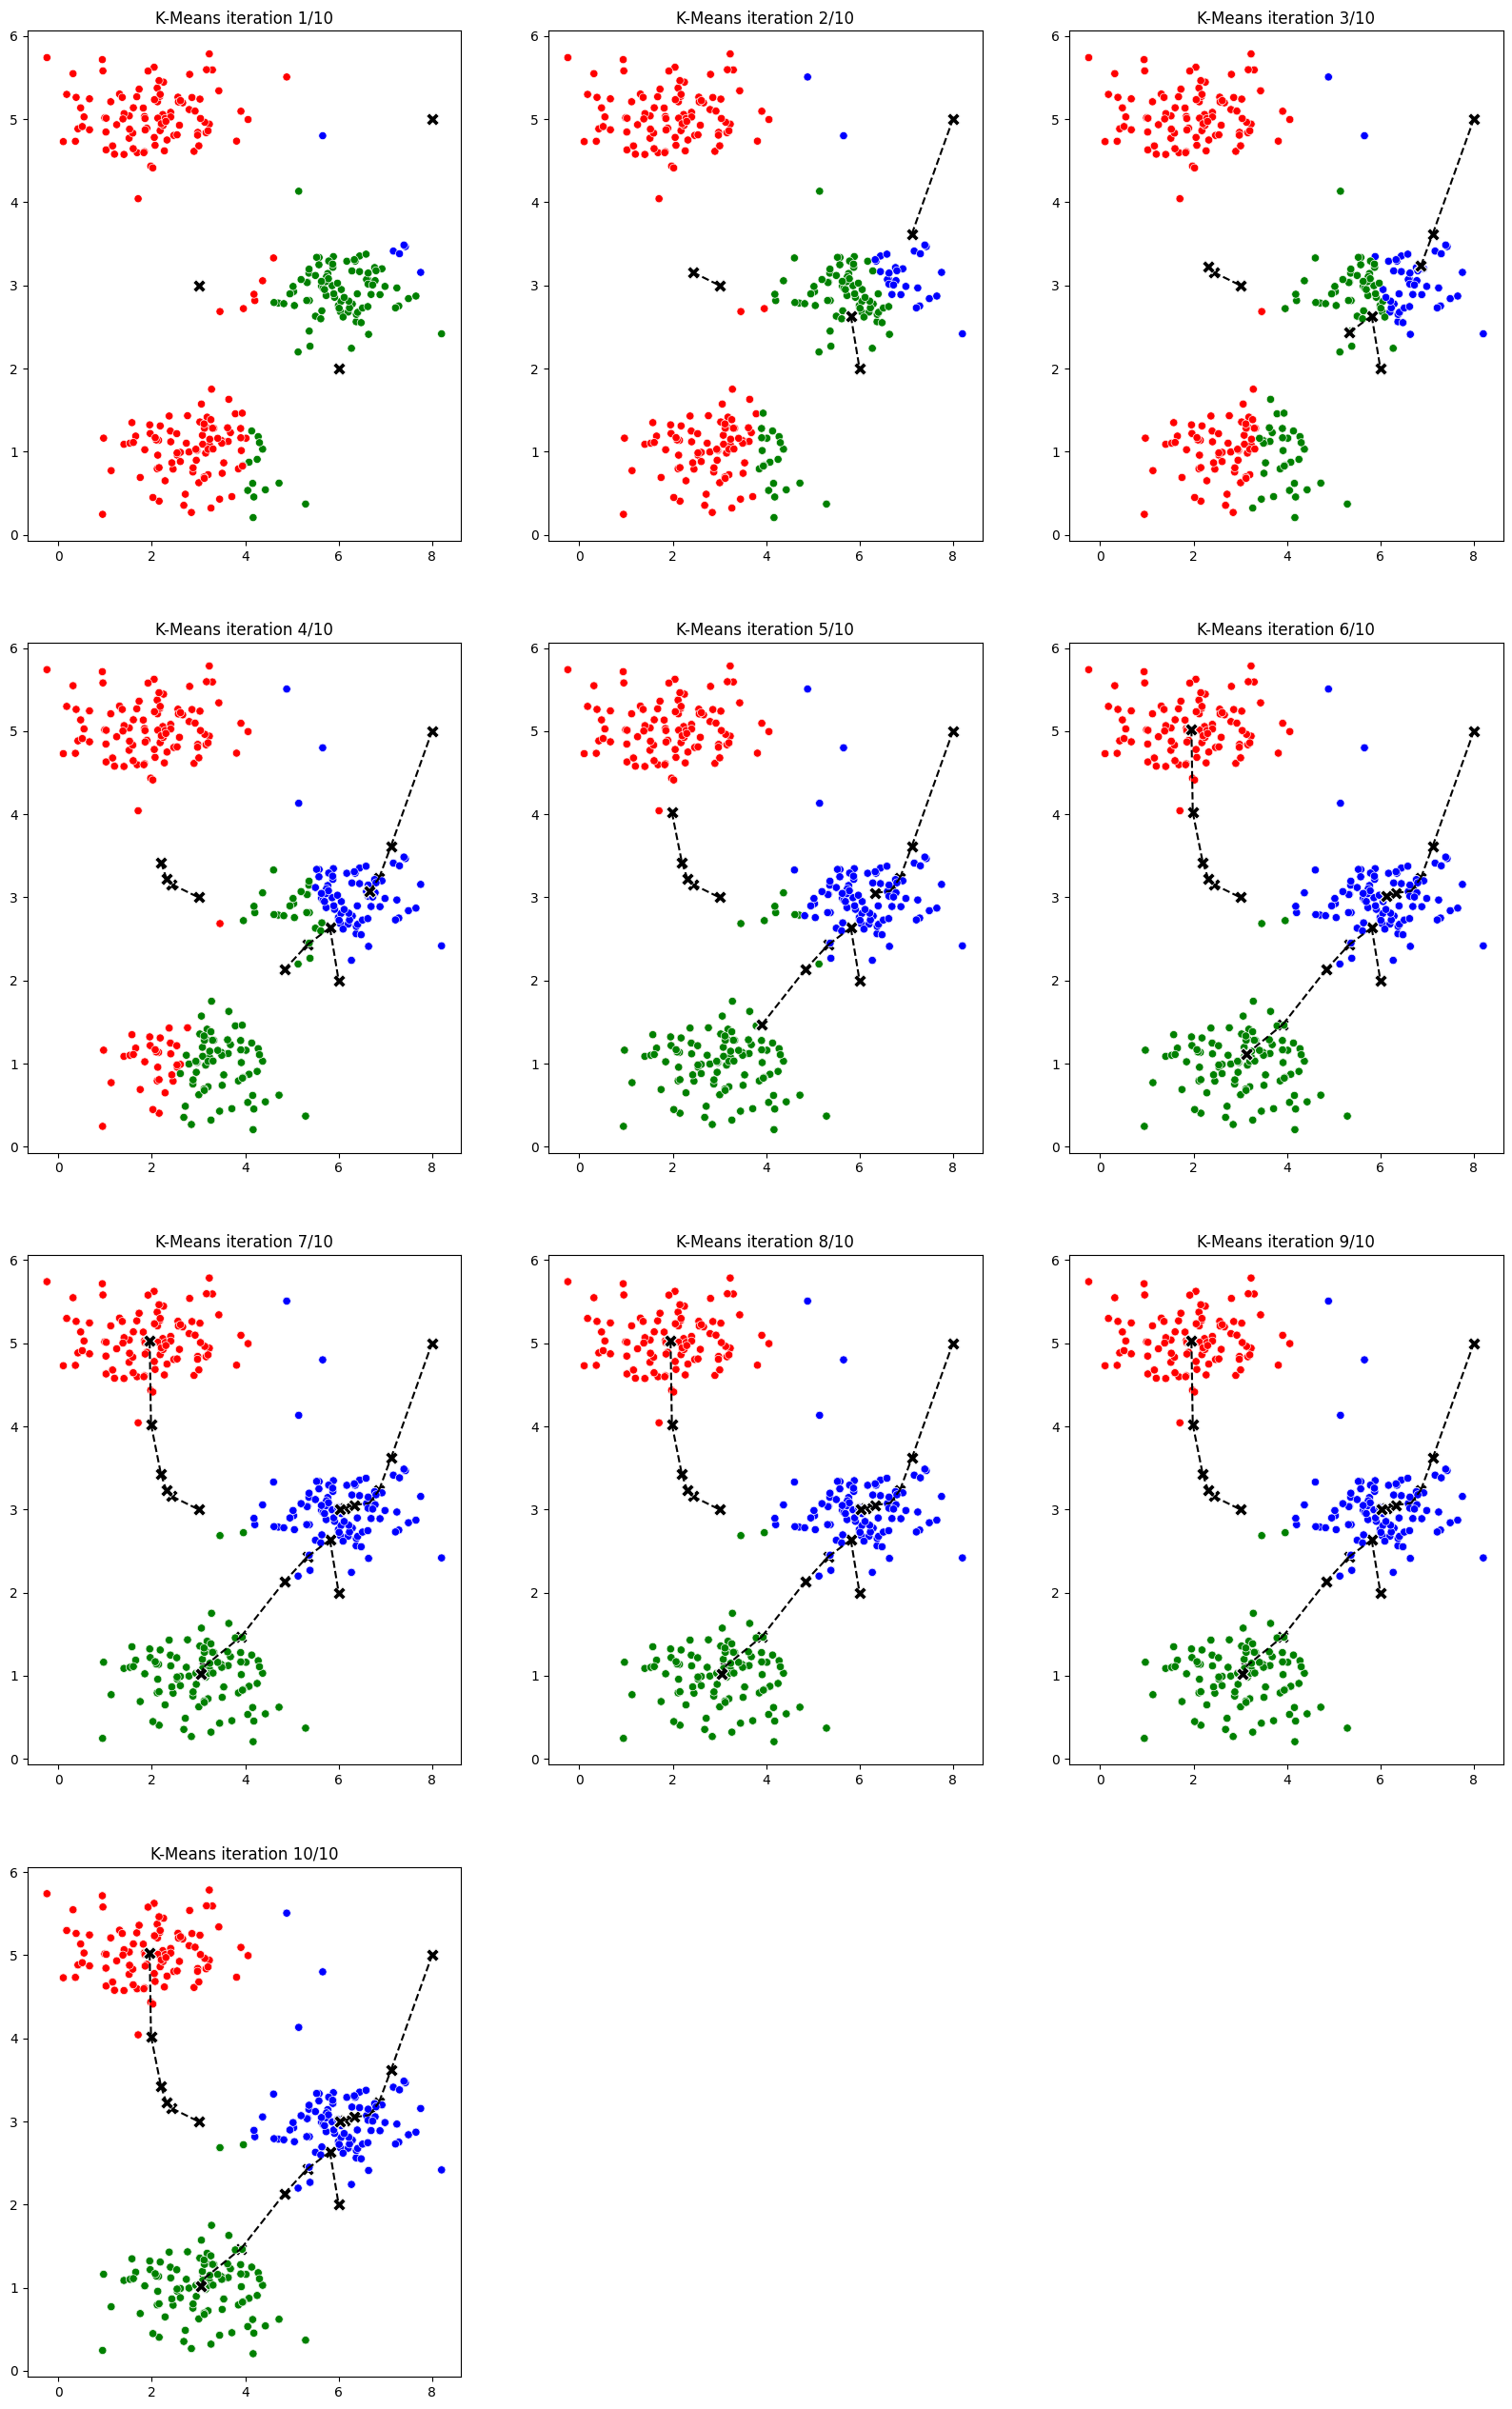

In [13]:
K = 3
max_iters = 10
initial_centroids = np.array([[3,3],[6,2],[8,5]])
centroids, idx = kmeans(mat['X'], initial_centroids, max_iters, True)

### 1.3 Random initialization

In [14]:
def init_random_centroids(X, K):
    centroids = X[(np.random.choice(X.shape[0], K)), :]
    return centroids

#### Equivalent Code using Scikit-Learn

In [15]:
from sklearn.cluster import KMeans
initial_centroids = np.array([[3,3],[6,2],[8,5]])
kmeans_model = KMeans(n_clusters=K, max_iter=max_iters, init=initial_centroids).fit(mat['X'])

Comparing the final centroids:

In [16]:
kmeans_model.cluster_centers_

array([[1.95399466, 5.02557006],
       [3.04367119, 1.01541041],
       [6.03366736, 3.00052511]])

In [17]:
centroids

array([[1.95399466, 5.02557006],
       [3.04367119, 1.01541041],
       [6.03366736, 3.00052511]])

Comparing labels of each point:

In [18]:
(kmeans_model.labels_.all()) == (idx.T[0].astype(int)-1).all()

np.True_

### 1.4 Image Compression with K-means

> In this exercise, you will use the K-means algorithm to select the 16 colors that will be used to represent the compressed image. Concretely, you will treat every pixel in the original image as a data example and use the K-means algorithm to find the 16 colors that best group (cluster) the pixels in the 3-dimensional RGB space. Once you have computed the cluster centroids on the image, you will then use the 16 colors to replace the pixels in the original image.

#### 1.4.1 K-means on pixels

##### Load image

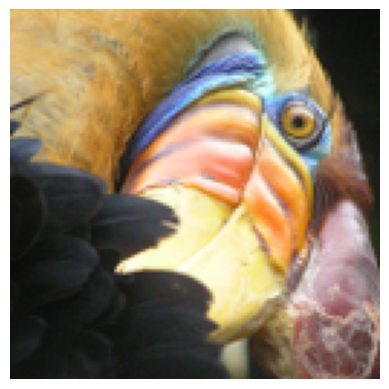

In [19]:
import cv2
img = cv2.imread('data/bird_small.png')
plt.axis('off');
plt.imshow(img[:,:,::-1]);

In [20]:
A = img[:,:,::-1]
A = np.divide(img, 255) #get all values in range 0-1

In [21]:
A.shape

(128, 128, 3)

In [22]:
A = A.reshape((A.shape[0]*A.shape[1], 3))

In [23]:
A.shape

(16384, 3)

##### Run K-Means

In [24]:
K = 16
max_iters = 10
initial_centroids = init_random_centroids(A, K)
centroids, idx = kmeans(A, initial_centroids, max_iters, False)

K-Means iteration 1/10
K-Means iteration 2/10
K-Means iteration 3/10
K-Means iteration 4/10
K-Means iteration 5/10
K-Means iteration 6/10
K-Means iteration 7/10
K-Means iteration 8/10
K-Means iteration 9/10
K-Means iteration 10/10


##### Apply K-Means to compress an image

In [25]:
idx = find_closest_centroid(A, centroids)
idx = idx.astype(int)

In [26]:
idx.shape

(16384, 1)

In [27]:
X_recovered = np.zeros((idx.shape[0], 3))
for i in range(idx.shape[0]):
    X_recovered[i,:] = centroids[idx[i]-1,:]

In [28]:
X_recovered = X_recovered.reshape((img.shape[0], img.shape[1], 3))

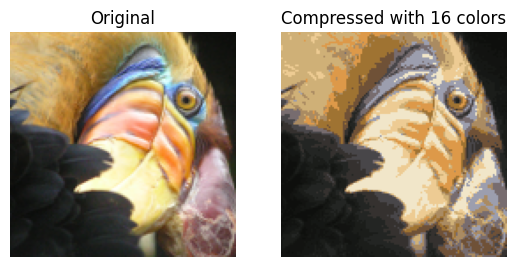

In [29]:
plt.subplot(1,2,1)
plt.axis('off');
plt.title('Original')
plt.imshow(img[:,:,::-1]);

plt.subplot(1,2,2)
plt.axis('off');
plt.title('Compressed with 16 colors')
plt.imshow(X_recovered[:,:,::-1]);

In [30]:
K_vals = [2, 8, 16, 24, 36]
max_iters = 10

imgs_compressed = []
for ik,K in enumerate(K_vals):
    print('\nRunning K-Means with K={}'.format(K))
    #run kmeans
    initial_centroids = init_random_centroids(A, K)
    centroids, idx = kmeans(A, initial_centroids, max_iters, False)
    #image compression
    idx = find_closest_centroid(A, centroids)
    idx = idx.astype(int)
    #recover image
    X_recovered = np.zeros((idx.shape[0], 3))
    for i in range(idx.shape[0]):
        X_recovered[i,:] = centroids[idx[i]-1,:]
    X_recovered = X_recovered.reshape((img.shape[0], img.shape[1], 3))
    imgs_compressed.append(X_recovered)


Running K-Means with K=2
K-Means iteration 1/10
K-Means iteration 2/10
K-Means iteration 3/10
K-Means iteration 4/10
K-Means iteration 5/10
K-Means iteration 6/10
K-Means iteration 7/10
K-Means iteration 8/10
K-Means iteration 9/10
K-Means iteration 10/10

Running K-Means with K=8
K-Means iteration 1/10
K-Means iteration 2/10
K-Means iteration 3/10
K-Means iteration 4/10
K-Means iteration 5/10
K-Means iteration 6/10
K-Means iteration 7/10
K-Means iteration 8/10
K-Means iteration 9/10
K-Means iteration 10/10

Running K-Means with K=16
K-Means iteration 1/10
K-Means iteration 2/10
K-Means iteration 3/10
K-Means iteration 4/10
K-Means iteration 5/10
K-Means iteration 6/10
K-Means iteration 7/10
K-Means iteration 8/10
K-Means iteration 9/10
K-Means iteration 10/10

Running K-Means with K=24
K-Means iteration 1/10
K-Means iteration 2/10
K-Means iteration 3/10
K-Means iteration 4/10
K-Means iteration 5/10
K-Means iteration 6/10
K-Means iteration 7/10
K-Means iteration 8/10
K-Means iteration

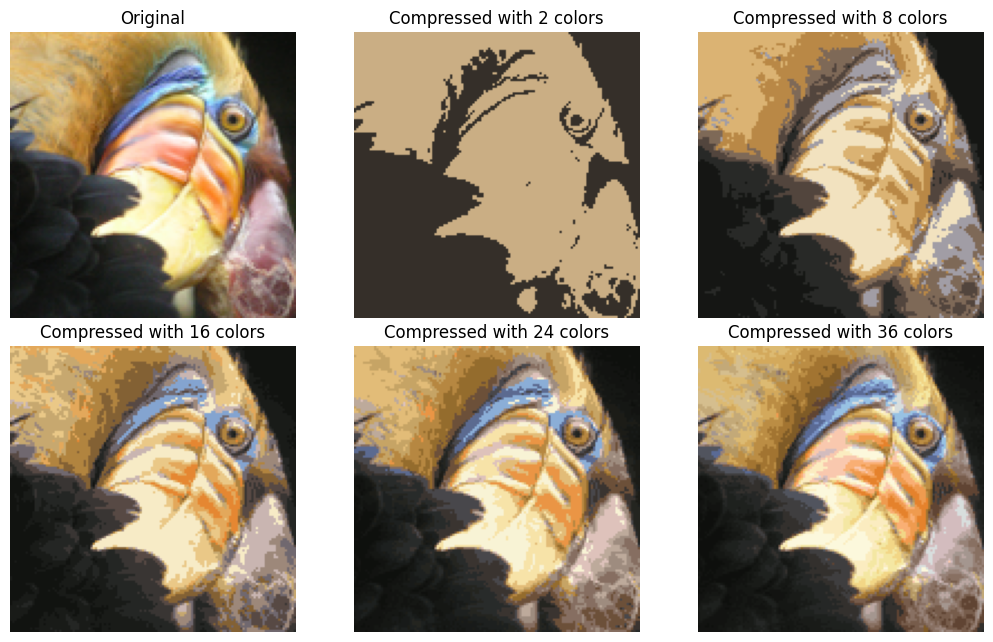

In [31]:
fig = plt.figure(figsize=(10,6))
rows = 2
cols = 3
ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(img[:,:,::-1])
ax1.set_axis_off()
ax1.set_title('Original')
for i in range(len(imgs_compressed)):
    ax1 = fig.add_subplot(rows, cols, i+2)
    ax1.imshow(imgs_compressed[i][:,:,::-1])
    ax1.set_axis_off()
    ax1.set_title('Compressed with {} colors'.format(K_vals[i]))
plt.subplots_adjust(wspace=.1, hspace=.1, left=0, right=1, bottom=0, top=1)
plt.show()